In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pprint
import copy
import seaborn as sns
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Imputer, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

C:\Users\nconidas\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nconidas\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load Data

The two primary files used here are the application_train csv and the installments_payments csv. The application_train has all of the input data that will be used as model inputs. The installments_payments csv has all of the payment information. In installments_payments each row corresponds to a payment and includes installment amount, actual payment amount, payment due data and actual payment date. 

In [3]:
#Notebook level configurations
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(indent=4)

# List input files, if not available please download from below url inot a /input.nosync folder
input_dir = 'input.nosync'
input_files = os.listdir(input_dir)
if input_files is None or len(input_files) < 10 :
    raise Exception('You do not have all the files in {} directory'.format(input_dir))

print('You have all the input files listed below')
# Read application_train.csv
app_train = pd.read_csv(input_dir+'/application_train.csv')

# Read installments_payments.csv
installments_payments = pd.read_csv(input_dir+'/installments_payments.csv')
print('Installment Payments Shape): ', installments_payments.shape)

You have all the input files listed below
Installment Payments Shape):  (13605401, 8)


### Preliminary Evaluation

Now that we have the data lets get an idea of the magnitude of the default problem

In [4]:
default = app_train[app_train.TARGET == 1]

default_payments = installments_payments.loc[
    installments_payments['SK_ID_CURR'].isin(default.SK_ID_CURR)]

#Total Value of Payments that were late
print('Late or Missing Payment Value :',
      ('$'+str(round(default_payments[default_payments.DAYS_INSTALMENT
                       < default_payments.DAYS_ENTRY_PAYMENT].AMT_INSTALMENT.sum()
       - default_payments[default_payments.DAYS_INSTALMENT
                       < default_payments.DAYS_ENTRY_PAYMENT].AMT_PAYMENT.sum(),2))))

print('Total number of Late or Missing Payments:', len(default_payments[default_payments.DAYS_INSTALMENT
                       < default_payments.DAYS_ENTRY_PAYMENT].AMT_INSTALMENT))

print('Number of unique distinct loans that ended in Default:', 
      len(default_payments['SK_ID_CURR'].unique()))

Late or Missing Payment Value : $204320021.62
Total number of Late or Missing Payments: 96919
Number of unique distinct loans that ended in Default: 23876


* Total on time payment discrepancy : \$47458527.12
* Total late payment discrepancy : \$204320021.62


### Pre-Process

In this section we will begin processing the application_train data.

In [5]:
#Create the output variable percentage repaid = Payment_Amount / Required_Payment_Amount
percentage_repaid = pd.DataFrame(default_payments.groupby('SK_ID_CURR').sum())[['AMT_INSTALMENT','AMT_PAYMENT']]
percentage_labels = percentage_repaid['AMT_PAYMENT'] / percentage_repaid['AMT_INSTALMENT']

#New DF to hold application info from just the defaulters (for whom we have payment data)
defaulter_data = app_train.loc[
    app_train['SK_ID_CURR'].isin(percentage_repaid.index)]

    
# split the training dataset into training (80%) and testing (20%)
split_ratio = 0.20
percentage_train_data, percentage_test_data, percentage_train_labels, percentage_test_labels = train_test_split(
    defaulter_data, percentage_labels, test_size = split_ratio, random_state = 23 )


# Move SK_ID_CURR to different object so that it does not interfer with classifier
percentage_train_data_skid_curr = percentage_train_data['SK_ID_CURR']
percentage_train_data = percentage_train_data.drop('SK_ID_CURR', axis=1)
percentage_test_data_skid_curr = percentage_test_data['SK_ID_CURR']
percentage_test_data = percentage_test_data.drop('SK_ID_CURR', axis=1)


### Data Clean

In this section we will deal with three issues: 
1. Missing Values
 <br> - Missing values will be replaced with 0
 <br> - any rows with missing values will be flagged in a Null Indicator column
2. Categorical Variables
 <br> - For columns with 2 or fewer unique values we'll use Sklearn's LabelEncoder
 <br> - For columns with 3 or more unique values we'll use Pandas get_dummies function
3. Scale Data
 <br> - Use Sklearn's MinMaxScaler to scale input data

In [6]:
#Change Null to 0's and add indicator column for each column having Null value
def replace_null_add_indicator(data):
    missing_values = data.isnull().sum()
    columns = list(data.columns)

    #print(missing_values)
    for i,missing_count in enumerate(missing_values):
        if missing_count > 0:
            original_column_name = columns[i]
            indicator_column_name = 'Null_Indicator_'+original_column_name 
            data[indicator_column_name] = data[original_column_name].isnull()
            data[original_column_name].fillna(value=0,inplace=True)
    

replace_null_add_indicator(percentage_train_data)
replace_null_add_indicator(percentage_test_data)

#Convert Categorical variables with <3 values to labels
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in list(percentage_train_data.columns):
    #print(col,app_train_data[col].dtype)
    if percentage_train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(percentage_train_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(percentage_train_data[col])
            # Transform both training and testing data
            percentage_train_data[col] = le.transform(percentage_train_data[col])
            percentage_test_data[col] = le.transform(percentage_test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1

#Create Dummy variables for any column with >2 unique categories
percentage_train_data = pd.get_dummies(percentage_train_data)
percentage_test_data = pd.get_dummies(percentage_test_data)

#align train_data and train_labels so columns match
percentage_train_data, percentage_test_data = (
    percentage_train_data.align(percentage_test_data, join = 'inner', axis = 1))

#remove any train_data rows corresponding to a na label
percentage_train_data = percentage_train_data.drop(
    percentage_train_data.index[pd.isnull(percentage_train_labels).nonzero()[0]])


#remove any rows with a na label
percentage_train_labels = percentage_train_labels.drop(
    percentage_train_labels.index[pd.isnull(percentage_train_labels).nonzero()[0]])

#Scale the data using MinMaxScaler
scaler=MinMaxScaler()
percentage_train_scaled = scaler.fit_transform(percentage_train_data)
percentage_test_scaled = scaler.fit_transform(percentage_test_data)



(19099, 302)
(4776, 302)


In order to get an idea of the level of difficulty in this task we look at the distribution of the percentage repaid
<br> We can see that there is a large spike at the mean (.96). The fact that so many defaulters paid back the same amount may lead the model to simply predict the mean value.

0.9676335463378057


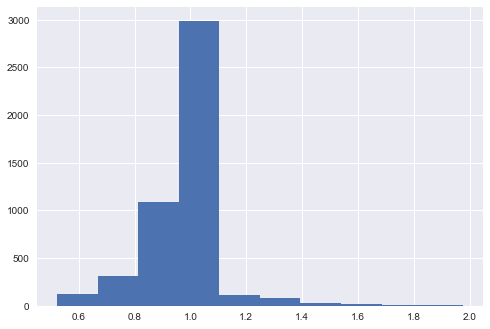

In [12]:
print(percentage_labels.mean())
percentage_test_labels.hist()

### Model Tuning

Now that we have the train and test data we can begin working on the model
<br> - We will be using a GradientBoostingRegressor tuned with GridSearchCV

In [17]:
#setup param dict for hyperparameter tuning
params = {'n_estimators':list(np.linspace(10,30,100,dtype=int))
          , 'max_depth':list(range(1,4))
          , 'min_samples_leaf':list(range(1,4))}

gs = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = params)
gs.fit(percentage_train_scaled,percentage_train_labels)

print(gs.best_params_)

KeyboardInterrupt: 

We now have the optimal hyperparameters so we can fit the model
make predictions and assess the accuracy
<br>
<br> We will use 3 metrics to assess the model performance
<br> 1. R2 : Variance explained by the model
<br>  - Possible values < 1 value of 0 means no better than always predicting E(Y)
<br> 2. median_absolute_error 
<br>  - Possible values : 0 to 1 (0 being the best) -chosen for insensitivity to outliers
<br> 3. root mean_squared_error 
<br>  -  Possible values :  0 - 1 (0 being the best) - Penalizes larger errors more harshly

0.0117094009119
0.0378045345964
0.126916854565


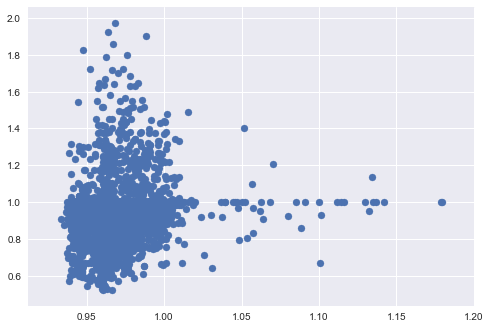

In [7]:
#Use a GradientBoostedRegressor to predict % repaid
gbt = GradientBoostingRegressor(max_depth=3,n_estimators=28, min_samples_leaf=1)
gbt.fit(percentage_train_scaled,percentage_train_labels)
predicts = gbt.predict(percentage_test_scaled)


print(metrics.explained_variance_score(percentage_test_labels,predicts))
print(metrics.median_absolute_error(percentage_test_labels,predicts))
print(metrics.mean_squared_error(percentage_test_labels,predicts)**.5)

plt.scatter(predicts,percentage_test_labels)


### Results

In the above scatter plot we can see that the model is predicting a wide range of values. However, based on the R2 score the model is doing only slightly better than it would if it only predicted E(Y). Possible improvement opportunities would be feature engineering exploration, including features based on domain knowledge and features from other data sources.

In [36]:
importances = gbt.feature_importances_
features = pd.DataFrame(percentage_test_data.columns, importances)
features.reset_index(inplace=True)
features.sort_values(by='index',ascending=False).head()

,index,0
108,0.223167,AMT_REQ_CREDIT_BUREAU_YEAR
82,0.134659,DAYS_LAST_PHONE_CHANGE
9,0.108921,AMT_GOODS_PRICE
8,0.043313,AMT_ANNUITY
1,0.039166,NAME_CONTRACT_TYPE
